# Attention Dynamics Analysis Around Nobel Recognition

In this notebook, I analyzed how public attention to economists changes over time, focusing specifically on Nobel Prize recipients. Using monthly Wikipedia pageview data, I aligned each laureate's attention trajectory relative to their Nobel award year, creating a time-centered measure of attention before and after recognition. This alignment allowed for direct comparison across individuals with different award years. 

I then examined aggregate attention trends to identify systematic patterns, such as whether pageviews tend to increase leading up to the award or peak shortly afterward. The analysis reveals a consistent surge in attention around the Nobel year, followed by a gradual decline, indicating that the Nobel Prize functions as a major visibility shock rather than a reflection of long-term public interest. By shifting the focus from prediction to temporal dynamics, this notebook demonstrates that while Wikipedia pageviews are weak predictors of Nobel outcomes, they are highly informative for understanding how major academic recognitions shape public attention over time.

***Note on Development**: In some sections, Generative AI was used for help with modeling. This use is explicitly documented with comments in the relevant code cells. 

**Table of Content**

1. [Set-up & Load Data](#sec1)
2. [Create Attention Features](#sec2)
3. [Growth Rate Feature](#sec3)
4. [Feature Comparison](#sec4)
5. [Visual Comparison - Boxplot](#sec5)
6. [Attention Volatility - Boxplot](#sec6)
7. [Spike Analysis](#sec7)
8. [Nobel-like Attention Ranking](#sec8)

<a id="sec1"></a>
### Set-up & Load Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_csv("../Data/nobel_combined.csv")

df.head()

,name,qid,date,views,nobel_year,is_nobel
0,Edith_Abbott,Q272731,201701,909,NaN,False
1,Edith_Abbott,Q272731,201702,1005,NaN,False
2,Edith_Abbott,Q272731,201703,1461,NaN,False
3,Edith_Abbott,Q272731,201704,901,NaN,False
4,Edith_Abbott,Q272731,201705,801,NaN,False


<a id="sec2"></a>
### Create Attention Features (Per Economist)

In [26]:
summary = (
    df.groupby(["qid", "name", "is_nobel"])
      .agg(
          mean_views=("views", "mean"),
          median_views=("views", "median"),
          std_views=("views", "std"),
          max_views=("views", "max"),
          total_views=("views", "sum"),
          active_months=("views", "count")
      )
      .reset_index()
)

summary.head()

,qid,name,is_nobel,mean_views,median_views,std_views,max_views,total_views,active_months
0,Q1005479,Jean-Jacques_Laffont,False,346.616822,293.0,139.194695,808,37088,107
1,Q101988,Helmut_Reichelt,False,174.626168,172.0,31.667650,312,18685,107
2,Q102402469,Matias_D._Cattaneo,False,79.615385,78.0,22.689340,111,2070,26
3,Q102454,Paul_Samuelson,False,10295.261682,10182.0,1747.544284,15189,1101593,107
4,Q102534442,Debraj_Ray_(economist),False,401.077670,361.0,212.844862,2291,41311,103


<a id="sec3"></a>
### Growth Rate Feature

In [27]:
def growth_rate(x):
    if len(x) < 2:
        return np.nan
    return (x.iloc[-1] - x.iloc[0]) / (x.iloc[0] + 1)

growth = (
    df.sort_values("date")
      .groupby("qid")["views"]
      .apply(growth_rate)
      .reset_index(name="growth_rate")
)

summary = summary.merge(growth, on="qid", how="left")
summary.head()

,qid,name,is_nobel,mean_views,median_views,std_views,max_views,total_views,active_months,growth_rate
0,Q1005479,Jean-Jacques_Laffont,False,346.616822,293.0,139.194695,808,37088,107,-0.405405
1,Q101988,Helmut_Reichelt,False,174.626168,172.0,31.667650,312,18685,107,0.358621
2,Q102402469,Matias_D._Cattaneo,False,79.615385,78.0,22.689340,111,2070,26,44.500000
3,Q102454,Paul_Samuelson,False,10295.261682,10182.0,1747.544284,15189,1101593,107,0.003039
4,Q102534442,Debraj_Ray_(economist),False,401.077670,361.0,212.844862,2291,41311,103,1.000000


<a id="sec4"></a>
### Feature Comparison - Nobel vs. Non-nobel

In [28]:
summary.groupby("is_nobel")[[
    "mean_views",
    "std_views",
    "growth_rate",
    "max_views"
]].mean()

,mean_views,std_views,growth_rate,max_views
is_nobel,,,,
False,4129.357517,2728.916154,5.082434,23722.850554
True,7538.383178,20941.433787,5.067155,217574.722222


<a id="sec5"></a>
### Visual Comparison - Nobel vs. Non-nobel - Boxplot

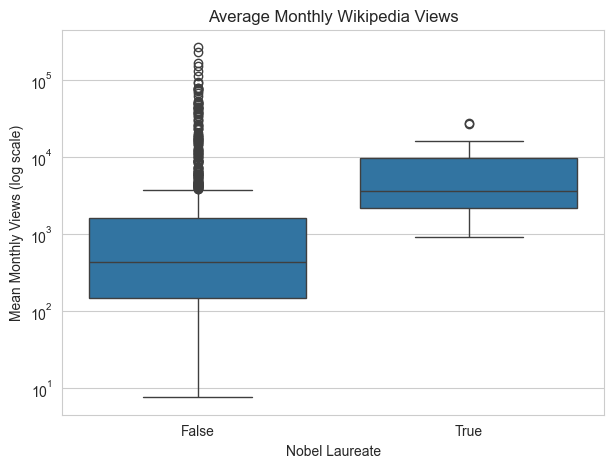

In [29]:
plt.figure(figsize=(7,5))
sns.boxplot(data=summary, x="is_nobel", y="mean_views")
plt.yscale("log")
plt.title("Average Monthly Wikipedia Views")
plt.xlabel("Nobel Laureate")
plt.ylabel("Mean Monthly Views (log scale)")
plt.show()

<a id="sec6"></a>
### Attention Volatility - Boxplot

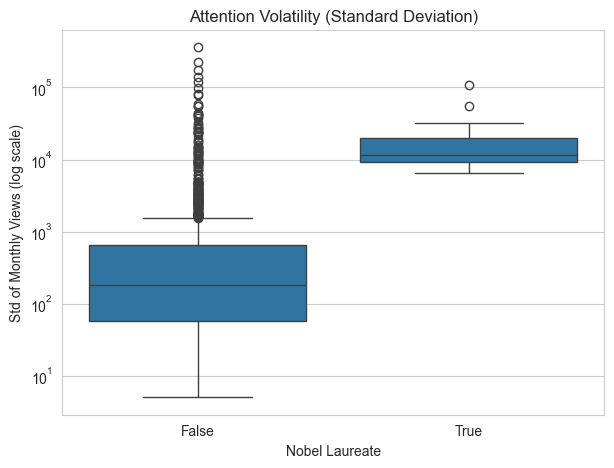

In [30]:
plt.figure(figsize=(7,5))
sns.boxplot(data=summary, x="is_nobel", y="std_views")
plt.yscale("log")
plt.title("Attention Volatility (Standard Deviation)")
plt.xlabel("Nobel Laureate")
plt.ylabel("Std of Monthly Views (log scale)")
plt.show()

<a id="sec7"></a>
### Spike Analysis

In [31]:
df["year"] = (df["date"] // 100).astype(int)
df.head()

,name,qid,date,views,nobel_year,is_nobel,year
0,Edith_Abbott,Q272731,201701,909,NaN,False,2017
1,Edith_Abbott,Q272731,201702,1005,NaN,False,2017
2,Edith_Abbott,Q272731,201703,1461,NaN,False,2017
3,Edith_Abbott,Q272731,201704,901,NaN,False,2017
4,Edith_Abbott,Q272731,201705,801,NaN,False,2017


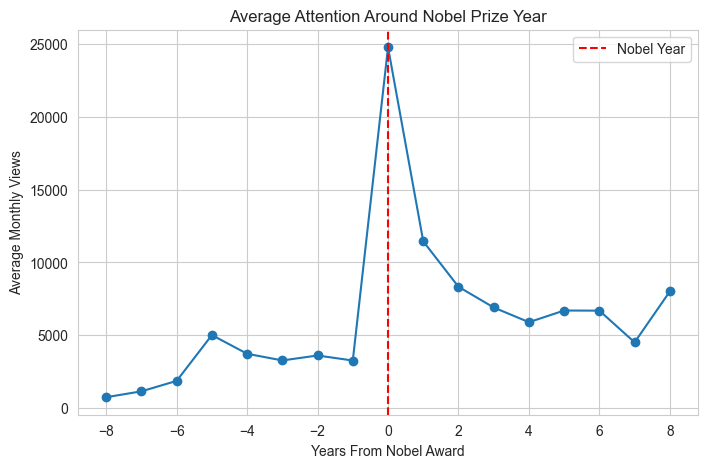

In [32]:
nobel_df = df[df["is_nobel"] == True].copy()

nobel_df["years_from_nobel"] = nobel_df["year"] - nobel_df["nobel_year"]

aligned = (
    nobel_df
    .groupby("years_from_nobel")["views"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
plt.plot(aligned["years_from_nobel"], aligned["views"], marker="o")
plt.axvline(0, color="red", linestyle="--", label="Nobel Year")
plt.legend()
plt.title("Average Attention Around Nobel Prize Year")
plt.xlabel("Years From Nobel Award")
plt.ylabel("Average Monthly Views")
plt.show()


<a id="sec8"></a>
### Nobel-like Attention Ranking

In [ ]:
# Generative AI was used below to assist with the set-up of the summary table
summary["attention_score"] = (
    np.log1p(summary["mean_views"]) +
    0.5 * np.log1p(summary["std_views"]) +
    0.3 * summary["growth_rate"].fillna(0)
)

ranked = summary.sort_values("attention_score", ascending=False)

ranked.head(15)[[
    "name", "is_nobel", "attention_score", "mean_views"
]]


,name,is_nobel,attention_score,mean_views
809,Lawrence_Bacow,False,713.154285,6402.710280
166,Luis_Arce,False,462.870314,19084.785714
80,Peter_St._Onge,False,98.897252,384.888889
668,Javier_Milei,False,71.395928,77326.617021
589,Adriana_Kugler,False,46.258160,2426.046729
955,Robert_Summers_(economist),False,42.736821,1053.375000
17,Michael_A._Lebowitz,False,42.635051,225.871795
5,Edmilson_Costa,False,40.357949,147.285714
566,Connel_Fullenkamp,False,34.718674,146.367347
963,Russell_W._Cooper,False,33.728014,79.579439
